# 1 - Instalações e Imports

In [ ]:
# === Célula 1: Instalações e Imports ===
!pip install optuna optuna-integration[tfkeras]

import os
import json
import datetime
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.saving import register_keras_serializable
import optuna
from optuna.integration import TFKerasPruningCallback
import matplotlib.pyplot as plt

# 2 - Métrica Customizada e Monitor

In [ ]:
# === Célula 2: Métrica Customizada e Monitor ===
@register_keras_serializable()
def custom_mae(y_true, y_pred):
    return tf.keras.losses.MAE(y_true, y_pred)

class TrainingMonitor(tf.keras.callbacks.Callback):
    def __init__(self, trial, fold, op_name):
        super().__init__()
        self.trial = trial
        self.fold = fold
        self.op_name = op_name
    def on_epoch_end(self, epoch, logs=None):
        print(f"[Op {self.op_name} | Trial {self.trial} | Fold {self.fold}] "
              f"Epoch {epoch+1}: val_mae={logs.get('val_mae'):.4f}")

# 3 - Geração e Split de Dados

In [40]:
# === Célula 3: Geração e Split de Dados ===
def gerar_dados(n_por_op=7000, seed=42):
    np.random.seed(seed)
    X, y = [], []
    for _ in range(n_por_op):
        a, b = np.random.uniform(1, 20), np.random.uniform(1, 20)
        ops = [a + b, a - b, a * b, a / b]
        for i, val in enumerate(ops):
            X.append([a, b, i])
            y.append(val)
    return np.array(X), np.array(y)

X, y = gerar_dados()
X, y = shuffle(X, y, random_state=42)
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=42)

# 4 - Pré‑processamento

In [41]:
# === Célula 4: Pré‑processamento ===
ε = 1e-6
scaler_num = StandardScaler().fit(X_train[:, :2])
ohe = OneHotEncoder(sparse_output=False).fit(X_train[:, 2].reshape(-1, 1))
scalers_y = {op: StandardScaler().fit(y_train[X_train[:, 2] == op].reshape(-1, 1)) for op in range(4)}

def preprocess(X_arr):
    a, b, op = X_arr[:,0], X_arr[:,1], X_arr[:,2].astype(int)
    feats = np.vstack([a*b, a/(b+ε), b/(a+ε), a**2, b**2]).T
    nums = scaler_num.transform(X_arr[:, :2])
    ops = ohe.transform(op.reshape(-1,1))
    return np.hstack([nums, ops, feats])

X_train_p = preprocess(X_train)
X_val_p   = preprocess(X_val)
X_test_p  = preprocess(X_test)

def get_indices(arr, op): return np.where(arr[:,2]==op)[0]

y_train_s = {op: scalers_y[op].transform(y_train[get_indices(X_train,op)].reshape(-1,1)).flatten() for op in range(4)}
y_val_s   = {op: scalers_y[op].transform(y_val[get_indices(X_val,op)].reshape(-1,1)).flatten()   for op in range(4)}

# 5 - Criação de Modelos com Optuna

In [42]:
# === Célula 5: Criação de Modelos com Optuna ===
optim_list = [('Adam', Adam), ('RMSprop', RMSprop), ('SGD', SGD)]

def criar_modelo(trial, input_dim):
    n_layers   = trial.suggest_int('n_layers', 1, 3)
    activation = trial.suggest_categorical('activation', ['relu','tanh','leaky'])
    dropout    = trial.suggest_float('dropout', 0.1, 0.3)
    l2_reg     = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)
    opt_idx    = trial.suggest_int('opt_idx', 0, 2)
    lr         = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    opt_name, Opt = optim_list[opt_idx]

    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(BatchNormalization())
    for i in range(n_layers):
        units = trial.suggest_int(f'units_{i}',32,128)
        if activation=='leaky':
            model.add(Dense(units, kernel_regularizer=regularizers.l2(l2_reg)))
            model.add(LeakyReLU())
        else:
            model.add(Dense(units, activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dropout(dropout))
    model.add(Dense(1))

    if Opt is SGD:
        m = trial.suggest_float('momentum',0.0,0.9)
        optimizer = SGD(learning_rate=lr, momentum=m, nesterov=True, clipnorm=1.0)
    elif Opt is RMSprop:
        r = trial.suggest_float('rho',0.8,0.99)
        optimizer = RMSprop(learning_rate=lr, rho=r, clipnorm=1.0)
    else:
        optimizer = Adam(learning_rate=lr, clipnorm=1.0)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model, opt_name


# 6 - Otimização com Optuna

In [43]:
# === Célula 6: Otimização com Optuna ===
def objective_factory(op):
    idxs = get_indices(X_train, op)
    Xi, yi = X_train_p[idxs], y_train_s[op]
    def objective(trial):
        bs = trial.suggest_categorical('batch_size',[32,64])
        kf = KFold(5, shuffle=True, random_state=42)
        maes=[]
        for fold,(ti,vi) in enumerate(kf.split(Xi),1):
            model,opt_name = criar_modelo(trial,Xi.shape[1])
            callbacks=[
                TFKerasPruningCallback(trial,'val_mae'),
                EarlyStopping('val_mae',mode='min',patience=10,restore_best_weights=True,verbose=0),
                TrainingMonitor(trial.number, fold, op)
            ]
            hist=model.fit(Xi[ti],yi[ti], validation_data=(Xi[vi],yi[vi]), epochs=100, batch_size=bs, callbacks=callbacks, verbose=0)
            maes.append(min(hist.history['val_mae']))
        return float(np.mean(maes))
    return objective

if not os.path.exists('best_params_ops.json'):
    best_params={}
    for op in range(4):
        study=optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
        study.optimize(objective_factory(op), n_trials=50)
        best_params[op]=study.best_params
        print(f"Op{op} best: {study.best_params}")
    with open('best_params_ops.json','w') as f: json.dump(best_params,f,indent=4)
else:
    print("Parâmetros já existem em best_params_ops.json")

Parâmetros já existem em best_params_ops.json


# 7 - Treino Final e Avaliação

In [44]:
# === Célula 7: Treino Final e Avaliação (com log‐transform para Op 2) ===
with open('best_params_ops.json','r') as f:
    best_params_ops = json.load(f)

maes_finais = {}
ts = datetime.datetime.now().strftime('%Y%m%d-%H%M')

for op_str, params in best_params_ops.items():
    op = int(op_str)
    # Índices de treino+val
    idx_tr = get_indices(X_train, op)
    idx_va = get_indices(X_val,   op)
    X_tr   = np.vstack([X_train_p[idx_tr], X_val_p[idx_va]])

    # Se operação 2 (multiplicação), use os alvos originais com log-transform
    if op == 2:
        y_tr_orig = np.hstack([y_train[idx_tr], y_val[idx_va]])
        y_va_orig = y_val[idx_va]
        y_tr = np.log1p(y_tr_orig).reshape(-1, 1)
        y_va = np.log1p(y_va_orig).reshape(-1, 1)
    else:
        # fluxo padrão com alvos padronizados
        y_tr = np.hstack([y_train_s[op], y_val_s[op]])
        y_va = y_val_s[op]

    # Reconstrói modelo com FixedTrial
    trial = optuna.trial.FixedTrial(params)
    model, _ = criar_modelo(trial, X_tr.shape[1])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_mae' if op != 2 else 'val_loss',
                      mode='min', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_mae' if op != 2 else 'val_loss',
                          mode='min', factor=0.5, patience=5),
        ModelCheckpoint(f'model_op{op}.keras',
                        monitor='val_mae' if op != 2 else 'val_loss',
                        mode='min', save_best_only=True),
        TrainingMonitor(None, 'final', op)
    ]

    # Ajusta epochs e batch_size conforme params
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val_p[idx_va], y_va),
        epochs=200,
        batch_size=params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    # Avaliação no teste
    idx_te = get_indices(X_test, op)
    X_te   = X_test_p[idx_te]

    # Se multiplicação, invertendo log-transform
    if op == 2:
        y_true = y_test[idx_te]
        y_pred_log = model.predict(X_te).flatten()
        y_pred = np.expm1(y_pred_log)
    else:
        y_pred_norm = model.predict(X_te).flatten()
        y_pred = scalers_y[op].inverse_transform(y_pred_norm.reshape(-1,1)).flatten()
        y_true = y_test[idx_te]

    mae = mean_absolute_error(y_true, y_pred)
    maes_finais[op] = mae
    print(f"Operação {op} MAE final: {mae:.4f}")

# Salva resultados
with open('maes_finais.json','w') as f:
    json.dump(maes_finais, f, indent=4)

Epoch 1/200
161/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3592 - mae: 0.4168[Op 0 | Trial None | Fold final] Epoch 1: val_mae=0.1259
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3454 - mae: 0.4061 - val_loss: 0.0545 - val_mae: 0.1259 - learning_rate: 3.0871e-04
Epoch 2/200
169/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1000 - mae: 0.2068[Op 0 | Trial None | Fold final] Epoch 2: val_mae=0.0820
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0998 - mae: 0.2065 - val_loss: 0.0373 - val_mae: 0.0820 - learning_rate: 3.0871e-04
Epoch 3/200
154/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0856 - mae: 0.1923[Op 0 | Trial None | Fold final] Epoch 3: val_mae=0.0552
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0859 - mae: 0.1931 - val_loss: 0.0296 - val_mae: 0.0552 - learning_rate: 3.0871e-04
Epoch 4/200
161/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0847 - mae: 0.1985[Op 0 | Trial None | Fold final] Epoch 4: val_mae=0.0555
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

# 8 - Exibição dos MAEs Finais

In [45]:
# === Célula 8: Exibição dos MAEs Finais ===
for op,mae_val in maes_finais.items(): print(f"Operação {op} — MAE final no teste: {mae_val:.4f}")

Operação 0 — MAE final no teste: 0.1068
Operação 1 — MAE final no teste: 0.1186
Operação 2 — MAE final no teste: 3.9654
Operação 3 — MAE final no teste: 0.0436


# 9 - Interface de Teste

In [49]:
# === Célula 9: Interface de Teste ===
def run_interface():
    models = {}
    for op in range(4):
        path = 'model_op2.keras' if op == 2 else f'model_op{op}.keras'
        models[op] = tf.keras.models.load_model(
            path,
            custom_objects={'custom_mae': custom_mae}
        )

    ops_names = ['Adição', 'Subtração', 'Multiplicação', 'Divisão']
    while True:
        c = input("\nEscolha\n 1 - Adição\n 2 - Subtração\n 3 - Multiplicação\n 4 - Divisão\n 5 - Sair\n > ")
        if c == '5':
            print("Encerrando interface.")
            break

        op = int(c) - 1
        a = float(input("Primeiro número: "))
        b = float(input("Segundo número: "))

        # Pré‑processamento comum
        Xn = scaler_num.transform([[a, b]])
        Xo = ohe.transform([[op]])
        feats = np.array([[a*b, a/(b+ε), b/(a+ε), a**2, b**2]])
        X_all = np.hstack([Xn, Xo, feats])

        # Predição
        pred_norm = models[op].predict(X_all, verbose=0)[0, 0]

        # Inversão de escala
        if op == 2:
            # Multiplicação — modelo log-domain
            p = np.expm1(pred_norm)
        else:
            # As outras operações usam scaler_y
            p = scalers_y[op].inverse_transform([[pred_norm]])[0, 0]

        # Cálculo de correto e feedback
        corr = [a+b, a-b, a*b, a/b][op]
        err  = abs(p - corr)
        if err < 0.1:
            fb = "Excelente!"
        elif err < 0.5:
            fb = "Bom"
        elif err < 1:
            fb = "Fique atento"
        else:
            fb = "Ops"

        print(f"{ops_names[op]} | Prev: {p:.4f} | Corr: {corr:.4f} | Erro: {err:.4f} | {fb}")

if __name__ == "__main__":
    run_interface()



Escolha
 1 - Adição
 2 - Subtração
 3 - Multiplicação
 4 - Divisão
 5 - Sair
 > 4
Primeiro número: 20
Segundo número: 10
Divisão | Prev: 2.0243 | Corr: 2.0000 | Erro: 0.0243 | Excelente!

Escolha
 1 - Adição
 2 - Subtração
 3 - Multiplicação
 4 - Divisão
 5 - Sair
 > 5
Encerrando interface.


# 10 - Gráficos de treinamento

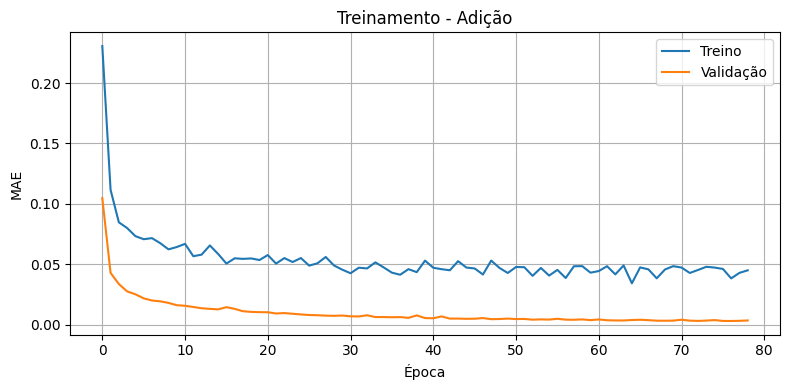

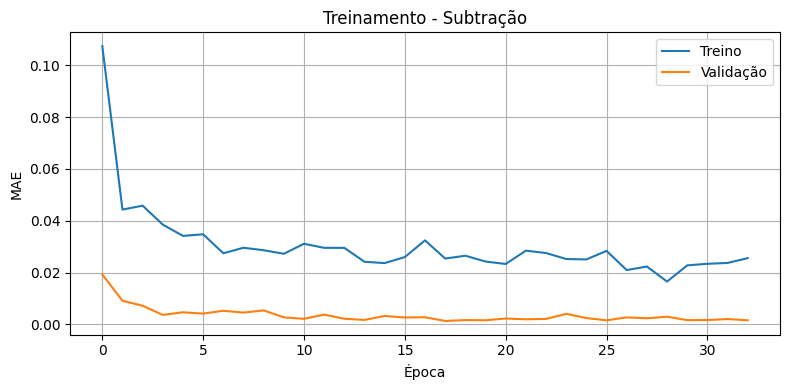

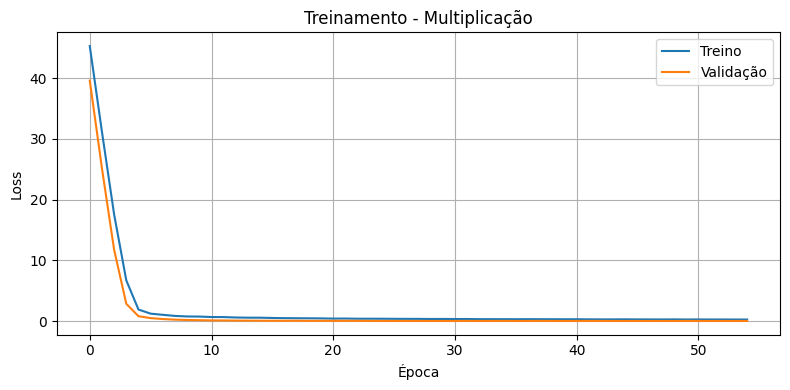

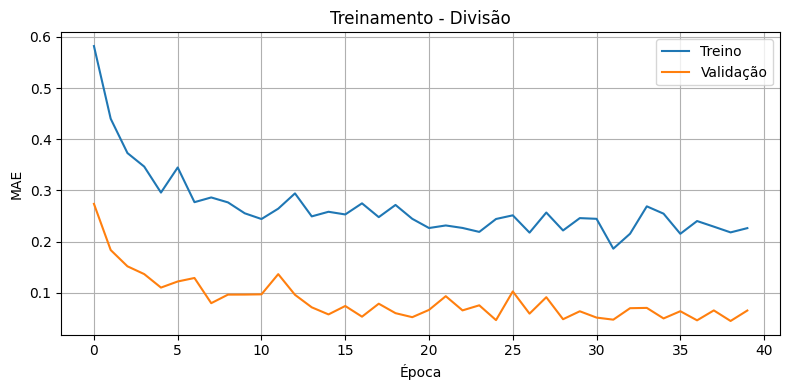

In [ ]:
# === Célula 10: Gráficos de Treinamento Final por Operação ===
import glob

def plot_history_from_checkpoint(model_path, op):
    # Carrega o modelo com callbacks para obter o histórico de treinamento
    history = None
    logs = []

    def collect_logs(epoch, logs_dict):
        logs.append(logs_dict.copy())

    dummy_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=collect_logs)

    # Dados de treino+val
    idx_tr = get_indices(X_train, op)
    idx_va = get_indices(X_val,   op)
    X_tr   = np.vstack([X_train_p[idx_tr], X_val_p[idx_va]])

    if op == 2:
        y_tr = np.log1p(np.hstack([y_train[idx_tr], y_val[idx_va]])).reshape(-1, 1)
        y_va = np.log1p(y_val[idx_va]).reshape(-1, 1)
    else:
        y_tr = np.hstack([y_train_s[op], y_val_s[op]])
        y_va = y_val_s[op]

    # Carrega os melhores parâmetros
    trial = optuna.trial.FixedTrial(best_params_ops[str(op)])
    model, _ = criar_modelo(trial, X_tr.shape[1])

    # Re-treina com callback para capturar histórico
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val_p[idx_va], y_va),
        epochs=150,
        batch_size=best_params_ops[str(op)]['batch_size'],
        callbacks=[dummy_cb, EarlyStopping(patience=15, restore_best_weights=True, monitor='val_mae' if op != 2 else 'val_loss')],
        verbose=0
    )

    # Converte para histórico
    history = {k: [e[k] for e in logs if k in e] for k in logs[0]}
    return history

# Plota para cada operação
ops_labels = ['Adição', 'Subtração', 'Multiplicação', 'Divisão']
for op in range(4):
    history = plot_history_from_checkpoint(f'model_op{op}.keras', op)
    plt.figure(figsize=(8,4))
    plt.plot(history['loss'], label='Treino')
    plt.plot(history['val_loss'], label='Validação')
    plt.title(f'Treinamento - {ops_labels[op]}')
    plt.xlabel('Época')
    plt.ylabel('Loss' if op == 2 else 'MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
